# Predicting Heart Disease using Machine Learning

## 1. Problem Definition
Given the clinical features about a patient, can we predict whether the patient has heart disease or not

## 2. Data
Dataset taken from: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data?select=heart.csv

## 3. Features
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]


## 4. Modelling

### 4.1 Loading and Inspecting the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC

In [2]:
# Importing the dataset
heart_disease = pd.read_csv("heart-disease-dataset.csv")

In [3]:
heart_disease.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Inspecting the dataset
heart_disease.shape, heart_disease.dtypes

((918, 12),
 Age                 int64
 Sex                object
 ChestPainType      object
 RestingBP           int64
 Cholesterol         int64
 FastingBS           int64
 RestingECG         object
 MaxHR               int64
 ExerciseAngina     object
 Oldpeak           float64
 ST_Slope           object
 HeartDisease        int64
 dtype: object)

In [5]:
# Checking for missing values
heart_disease.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# Checking class balance
heart_disease.value_counts(["HeartDisease"])

HeartDisease
1               508
0               410
Name: count, dtype: int64

### 4.2 Splitting the data

In [7]:
X = heart_disease.drop("HeartDisease", axis=1)
y = heart_disease["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 4.3 Converting data into a numeric format

In [8]:
# Defining categorical & numeric column

numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_features = [
    "Sex", "ChestPainType", "FastingBS",
    "RestingECG", "ExerciseAngina", "ST_Slope"
]

In [9]:
# Preprocessing the columns
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### 4.4 Model Selection

In [10]:
# Model dictionary
models = {
    "LogisticRegression": LogisticRegression(),
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42)
}

In [11]:
# Cross-validation & scoring setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
}

In [12]:
# Model Evaluation Loop
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    results[name] = {
        "Accuracy_mean": np.mean(cv_results["test_accuracy"]),
        "Recall_mean": np.mean(cv_results["test_recall"]),
        "Precision_mean": np.mean(cv_results["test_precision"]),
        "F1_mean": np.mean(cv_results["test_f1"]),
    }

pd.DataFrame(results).T

,Accuracy_mean,Recall_mean,Precision_mean,F1_mean
LogisticRegression,0.851552,0.879404,0.858755,0.868326
LinearSVC,0.850191,0.876935,0.858488,0.866909
KNN,0.844721,0.891659,0.839843,0.864424
RandomForest,0.850163,0.894219,0.847158,0.868843


<Axes: >

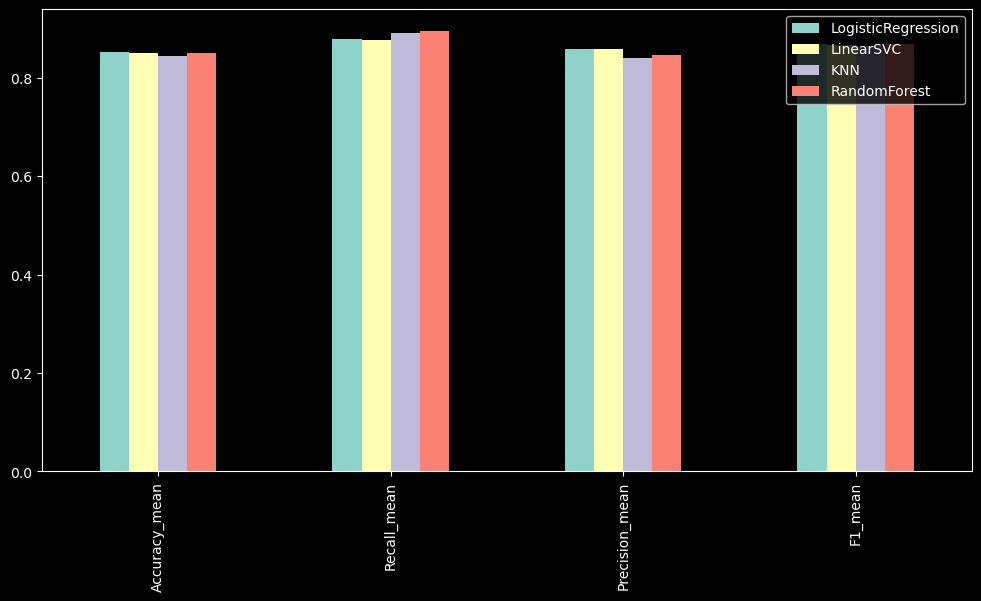

In [13]:
pd.DataFrame(results).plot.bar(figsize=(12, 6))

### 4.4.1 Selecting `RandomForest` and `LogisticRegression` for hyperparameter tuning

Since both recall and precision are important in screening, F1 is used for tuning.

#### 4.4.1.2 `RandomForestClassifier`

In [14]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 15, 25],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
}

random_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 15, ...], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_leaf': [1, 2], 'model__min_samples_split': [2, 5], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [15]:
# Evaluating the random forest model
best_rf_model = random_search_rf.best_estimator_
best_y_preds_rf = best_rf_model.predict(X_test)
best_y_probs_rf = best_rf_model.predict_proba(X_test)[:, 1]

In [18]:
# Comparing the F1 score with the baseline model
print(f"Original recall score {results['RandomForest']['F1_mean']}")

cv_res_rf_tuned = cross_validate(
    best_rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print(f"Best F1 score {np.mean(cv_res_rf_tuned['test_f1'])}")

Original recall score 0.8688427911268427
Best F1 score 0.879194799258429


In [19]:
# tuned model is better
# further evaluation
report_rf = classification_report(y_test, best_y_preds_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



In [20]:
# confusion matrix custom function
def dispo_confusion_matrix(y_true, y_preds, mdl):
    cm = confusion_matrix(y_true, y_preds, labels=mdl.classes_, normalize="true")

    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=mdl.classes_
    )

    disp.plot(
        cmap="Blues",
        values_format=".2f",
        ax=ax,
        colorbar=True
    )

    plt.title("Normalized Confusion Matrix")
    plt.grid(False)
    plt.show()

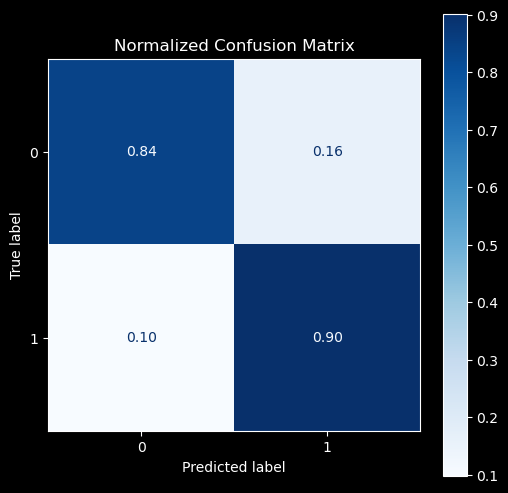

In [21]:
# confusion matrix for RandomForest
dispo_confusion_matrix(y_test, best_y_preds_rf, best_rf_model)

#### 4.4.1.2 `LogisicRegression`

In [22]:
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

param_grid = [
    {
        "model__penalty": ["l2"],
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__solver": ["lbfgs", "liblinear"],
        "model__class_weight": [None, "balanced"],
        "model__max_iter": [1000]
    },
    {
        "model__penalty": ["l1"],
        "model__C": [0.001, 0.01, 0.1, 1, 10],
        "model__solver": ["liblinear"],
        "model__class_weight": [None, "balanced"],
        "model__max_iter": [1000]
    }
]

random_search_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
)

random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 34 candidates, totalling 170 fits


,estimator,Pipeline(step...egression())])
,param_grid,"[{'model__C': [0.001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__max_iter': [1000], 'model__penalty': ['l2'], ...}, {'model__C': [0.001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__max_iter': [1000], 'model__penalty': ['l1'], ...}]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [23]:
# Evaluating the logistic regression
best_lr_model = random_search_lr.best_estimator_
best_y_preds_lr = best_lr_model.predict(X_test)
best_y_probs_lr = best_lr_model.predict_proba(X_test)[:, 1]

In [24]:
# comparing the F1 score with the baseline model
print(f"Original recall score {results['LogisticRegression']['F1_mean']}")

cv_res_lr_tuned = cross_validate(
    best_lr_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print(f"Best F1 score {np.mean(cv_res_lr_tuned['test_f1'])}")

Original recall score 0.8683259197428945
Best F1 score 0.8696710786490289


Because the dataset was simple LR was already close to optimal

In [25]:
# further evaluation
report_lr = classification_report(y_test, best_y_preds_lr)
print(report_lr)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



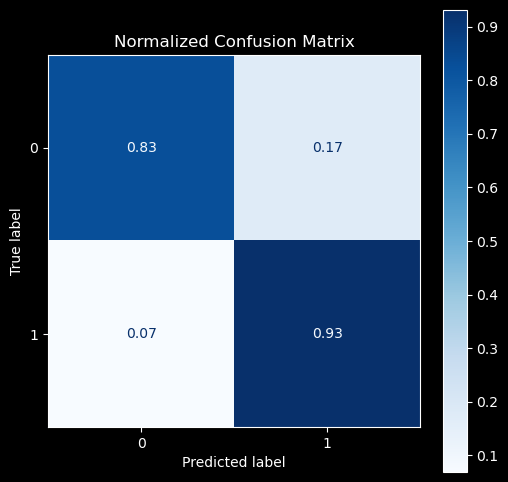

In [26]:
dispo_confusion_matrix(y_test, best_y_preds_lr, best_lr_model)

#### 4.4.1.3 Plotting the precision-Recall Curves

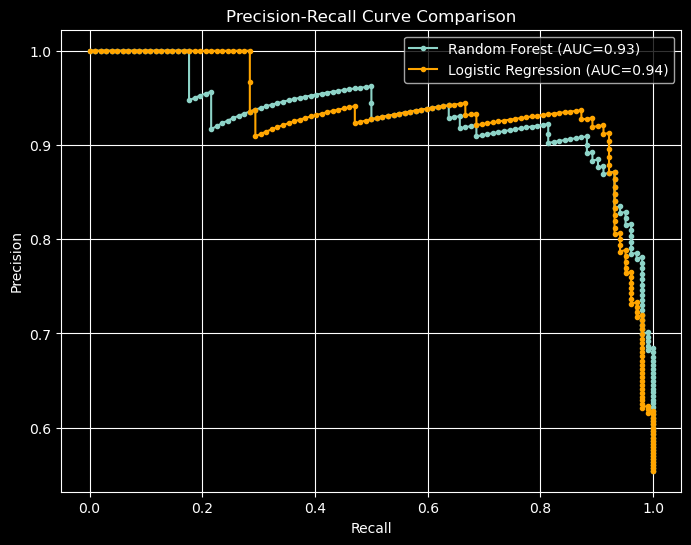

In [27]:
# plotting the precision recall curve for both the models
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, best_y_probs_rf)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, best_y_probs_lr)

# Compute AUC for each model
auc_rf = auc(recall_rf, precision_rf)
auc_lr = auc(recall_lr, precision_lr)

plt.figure(figsize=(8, 6))

plt.plot(recall_rf, precision_rf, marker='.', label=f'Random Forest (AUC={auc_rf:.2f})')
plt.plot(recall_lr, precision_lr, marker='.', label=f'Logistic Regression (AUC={auc_lr:.2f})', color='orange')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# The selected model is the logistic regression model
Because:
   1. Logistic Regression achieved the highest recall (0.93)
   2. Had acceptable precision (0.87)
   3. PR-AUC slightly better than RF

In [28]:
# final metrics
print(report_lr)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



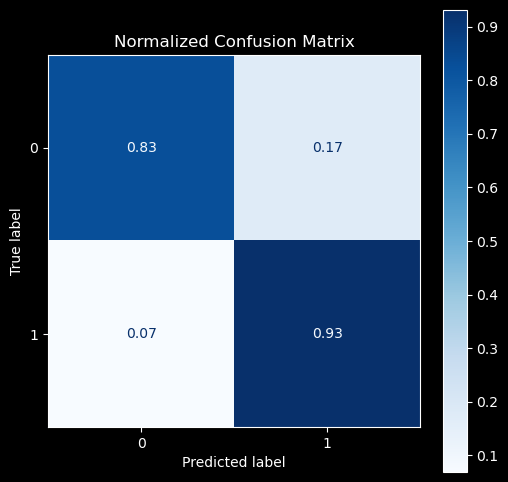

In [29]:
dispo_confusion_matrix(y_test, best_y_preds_lr, best_lr_model)

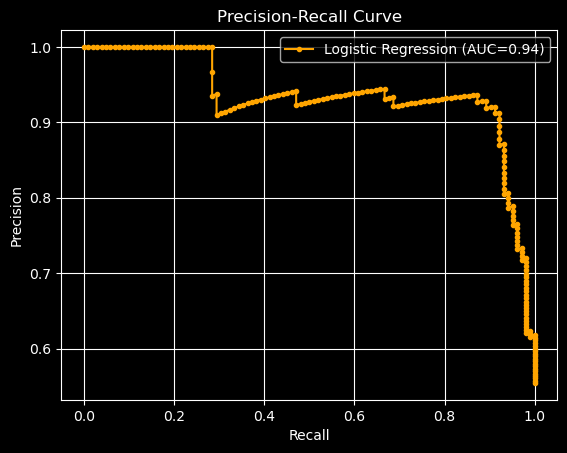

In [30]:
plt.plot(recall_lr, precision_lr, marker='.', label=f'Logistic Regression (AUC={auc_lr:.2f})', color='orange')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()